In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
import random


class MoneyAgent(Agent):
    """Creates An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        """The agents' action at each step - if they have money,
        they give one unit of money to another, random agent"""
        if self.wealth == 0:
            return
        other_agent = random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1


class MoneyModel(Model):
    """A model with random number of agents."""
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

    def step(self):
        """Advance the model by one step"""
        self.schedule.step()

In [5]:
# Runs the model 10 times, for each time, model moves 1 step
model = MoneyModel(10)
for i in range(10):
    model.step()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


(array([ 4.,  0.,  0.,  3.,  0.,  0.,  2.,  0.,  0.,  1.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

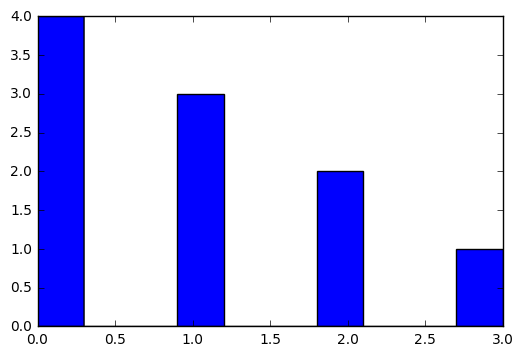

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

(array([ 432.,  304.,  143.,   83.,   31.,    7.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

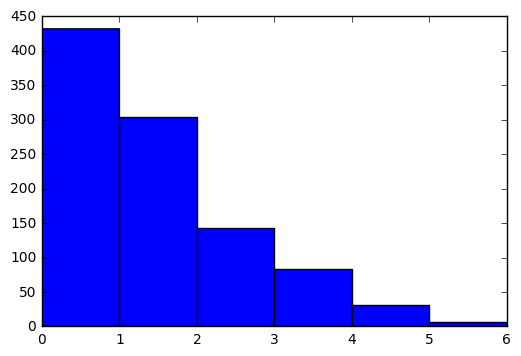

In [7]:
# 100 runs of the 10-step model - decreases noise from randomness
all_wealth = []
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()
        
    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth)+1))

In [10]:
"""Adding a spatial element where agents move on a grid and instead
of giving their money to a random agent, they give their money to an
agent on the same grid as they"""
from mesa.space import MultiGrid


class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
        
            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
        
    def step(self):
        self.schedule.step()
        
        
class MoneyAgent(Agent):
    """Creates An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1
        
    def move(self):
        """Two ways of determining neighbors with get_neighborhood:
        Moore, which includes diagonals, and Von Neumann, which is only 
        up/down/left/right & also need to include argument saying 
        whether or not the central cell is considered a neighbor"""
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
    def give_money(self):
        """Get all of the agents present in a cell and give money
        to one of them"""
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1
    
    def step(self):
        # Now just refers back to give_money method if money > 0
        self.move()
        if self.wealth > 0:
            self.give_money()

In [11]:
# Create a model with 50 agents on a 10x10 grid, run for 20 steps
model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()

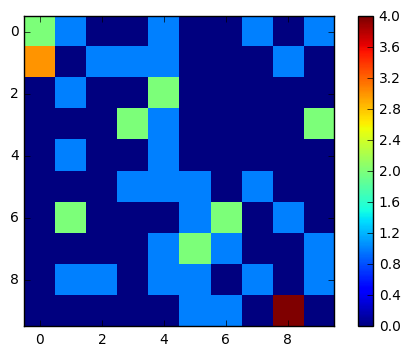

In [12]:
"""Visualize # of agents in each grid: create numpy array same size
as grid, filled with zeros and then loop through every cell in the grid
to get coordinates and contents"""
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

In [21]:
"""Data collection for the model using the collect method that
applies a method-level collection function to the model and then
stores the results in a dictionary - current value at each step for
each agent identified by unique_id to get. Collecting Gini Coefficient,
a measure of wealth inequality"""
from mesa.datacollection import DataCollector

def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N-i) for i, xi in enumerate(x)) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": lambda a: a.wealth})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [ ]:
# Create a model with 50 agents on a 10x10 grid, run for 100 steps
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

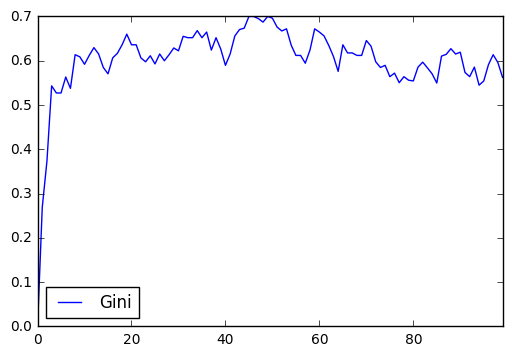

In [25]:
# Get the series of Gini coefficients as a pandas DataFrame
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [26]:
# Get agent wealth data
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

<div>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th></th>
      <th>Wealth</th>
    </tr>
    <tr>
      <th>Step</th>
      <th>AgentID</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="5" valign="top">0</th>
      <th>0</th>
      <td>1</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1</td>
    </tr>
    <tr>
      <th>2</th>
      <td>1</td>
    </tr>
    <tr>
      <th>3</th>
      <td>1</td>
    </tr>
    <tr>
      <th>4</th>
      <td>1</td>
    </tr>
  </tbody>
</table>
</div>

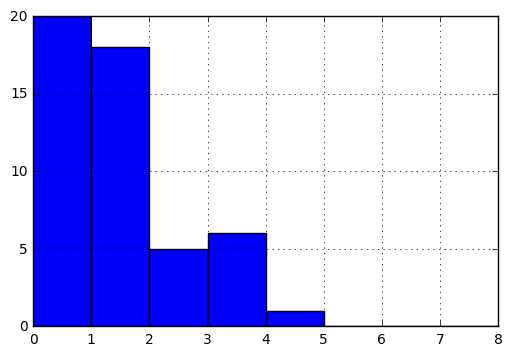

In [27]:
# Get histogram of agent wealth at the end of the model
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

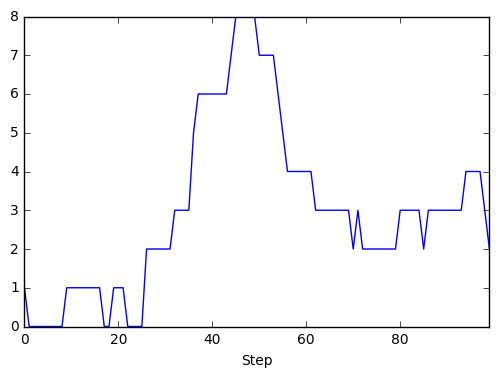

In [29]:
# Plot the wealth of a given agent
one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

In [30]:
"""Batch Run - needs additional variable in MoneyModel class"""
from mesa.batchrunner import BatchRunner


class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": lambda a: a.wealth})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

#Set up and run the BatchRunner
parameters = {"width": 10,
              "height": 10,
              "N": range(10, 500, 10)}

batch_run = BatchRunner(MoneyModel,
                        parameters,
                        iterations=5,
                        max_steps=100,
                        model_reporters={"Gini": compute_gini})

batch_run.run_all()

  0%|          | 0/245 [00:00<?, ?it/s]

  2%|▏         | 5/245 [00:00<00:05, 40.84it/s]

  3%|▎         | 8/245 [00:00<00:07, 32.31it/s]

  4%|▍         | 11/245 [00:00<00:08, 27.07it/s]

  5%|▌         | 13/245 [00:00<00:10, 22.15it/s]

  6%|▌         | 15/245 [00:00<00:11, 19.59it/s]

  7%|▋         | 17/245 [00:00<00:14, 16.01it/s]

  8%|▊         | 19/245 [00:01<00:16, 13.83it/s]

  9%|▊         | 21/245 [00:01<00:18, 12.32it/s]

  9%|▉         | 23/245 [00:01<00:19, 11.10it/s]

 10%|█         | 25/245 [00:01<00:21, 10.30it/s]

 11%|█         | 27/245 [00:01<00:23,  9.32it/s]

 11%|█▏        | 28/245 [00:02<00:25,  8.54it/s]

 12%|█▏        | 29/245 [00:02<00:26,  8.15it/s]

 12%|█▏        | 30/245 [00:02<00:27,  7.93it/s]

 13%|█▎        | 31/245 [00:02<00:28,  7.45it/s]

 13%|█▎        | 32/245 [00:02<00:29,  7.15it/s]

 13%|█▎        | 33/245 [00:02<00:32,  6.62it/s]

 14%|█▍        | 34/245 [00:03<00:32,  6.50it/s]

 14%|█▍        | 35/245 [00:03<00:32,  6.47it/s]

 15%|█▍        | 36/245 [00:03<00:34,  6.14it/s]

 15%|█▌        | 37/245 [00:03<00:34,  5.97it/s]

 16%|█▌        | 38/245 [00:03<00:35,  5.87it/s]

 16%|█▌        | 39/245 [00:03<00:35,  5.82it/s]

 16%|█▋        | 40/245 [00:04<00:35,  5.78it/s]

 17%|█▋        | 41/245 [00:04<00:36,  5.58it/s]

 17%|█▋        | 42/245 [00:04<00:37,  5.45it/s]

 18%|█▊        | 43/245 [00:04<00:38,  5.29it/s]

 18%|█▊        | 44/245 [00:04<00:39,  5.13it/s]

 18%|█▊        | 45/245 [00:05<00:39,  5.02it/s]

 19%|█▉        | 46/245 [00:05<00:41,  4.83it/s]

 19%|█▉        | 47/245 [00:05<00:41,  4.73it/s]

 20%|█▉        | 48/245 [00:05<00:42,  4.63it/s]

 20%|██        | 49/245 [00:05<00:43,  4.48it/s]

 20%|██        | 50/245 [00:06<00:44,  4.43it/s]

 21%|██        | 51/245 [00:06<00:44,  4.35it/s]

 21%|██        | 52/245 [00:06<00:44,  4.30it/s]

 22%|██▏       | 53/245 [00:06<00:45,  4.27it/s]

 22%|██▏       | 54/245 [00:07<00:45,  4.22it/s]

 22%|██▏       | 55/245 [00:07<00:45,  4.16it/s]

 23%|██▎       | 56/245 [00:07<00:46,  4.04it/s]

 23%|██▎       | 57/245 [00:07<00:47,  3.93it/s]

 24%|██▎       | 58/245 [00:08<00:51,  3.63it/s]

 24%|██▍       | 59/245 [00:08<00:50,  3.69it/s]

 24%|██▍       | 60/245 [00:08<00:49,  3.73it/s]

 25%|██▍       | 61/245 [00:09<00:50,  3.64it/s]

 25%|██▌       | 62/245 [00:09<00:50,  3.62it/s]

 26%|██▌       | 63/245 [00:09<00:51,  3.55it/s]

 26%|██▌       | 64/245 [00:09<00:51,  3.54it/s]

 27%|██▋       | 65/245 [00:10<00:51,  3.52it/s]

 27%|██▋       | 66/245 [00:10<00:52,  3.42it/s]

 27%|██▋       | 67/245 [00:10<00:52,  3.36it/s]

 28%|██▊       | 68/245 [00:11<00:56,  3.13it/s]

 28%|██▊       | 69/245 [00:11<00:57,  3.04it/s]

 29%|██▊       | 70/245 [00:11<00:57,  3.04it/s]

 29%|██▉       | 71/245 [00:12<00:59,  2.92it/s]

 29%|██▉       | 72/245 [00:12<00:58,  2.94it/s]

 30%|██▉       | 73/245 [00:12<00:59,  2.90it/s]

 30%|███       | 74/245 [00:13<00:58,  2.90it/s]

 31%|███       | 75/245 [00:13<00:57,  2.96it/s]

 31%|███       | 76/245 [00:13<00:58,  2.90it/s]

 31%|███▏      | 77/245 [00:14<01:02,  2.68it/s]

 32%|███▏      | 78/245 [00:14<01:07,  2.47it/s]

 32%|███▏      | 79/245 [00:15<01:09,  2.38it/s]

 33%|███▎      | 80/245 [00:15<01:07,  2.44it/s]

 33%|███▎      | 81/245 [00:16<01:07,  2.44it/s]

 33%|███▎      | 82/245 [00:16<01:07,  2.43it/s]

 34%|███▍      | 83/245 [00:16<01:05,  2.47it/s]

 34%|███▍      | 84/245 [00:17<01:03,  2.54it/s]

 35%|███▍      | 85/245 [00:17<01:01,  2.60it/s]

 35%|███▌      | 86/245 [00:18<01:02,  2.56it/s]

 36%|███▌      | 87/245 [00:18<01:01,  2.55it/s]

 36%|███▌      | 88/245 [00:18<01:03,  2.48it/s]

 36%|███▋      | 89/245 [00:19<01:05,  2.40it/s]

 37%|███▋      | 90/245 [00:19<01:03,  2.43it/s]

 37%|███▋      | 91/245 [00:20<01:03,  2.43it/s]

 38%|███▊      | 92/245 [00:20<01:03,  2.42it/s]

 38%|███▊      | 93/245 [00:21<01:02,  2.43it/s]

 38%|███▊      | 94/245 [00:21<01:02,  2.43it/s]

 39%|███▉      | 95/245 [00:21<01:02,  2.38it/s]

 39%|███▉      | 96/245 [00:22<01:04,  2.31it/s]

 40%|███▉      | 97/245 [00:22<01:05,  2.25it/s]

 40%|████      | 98/245 [00:23<01:05,  2.25it/s]

 40%|████      | 99/245 [00:23<01:05,  2.23it/s]

 41%|████      | 100/245 [00:24<01:06,  2.20it/s]

 41%|████      | 101/245 [00:24<01:06,  2.18it/s]

 42%|████▏     | 102/245 [00:25<01:06,  2.16it/s]

 42%|████▏     | 103/245 [00:25<01:05,  2.18it/s]

 42%|████▏     | 104/245 [00:26<01:05,  2.15it/s]

 43%|████▎     | 105/245 [00:26<01:04,  2.16it/s]

 43%|████▎     | 106/245 [00:26<01:05,  2.13it/s]

 44%|████▎     | 107/245 [00:27<01:08,  2.00it/s]

 44%|████▍     | 108/245 [00:28<01:08,  2.01it/s]

 44%|████▍     | 109/245 [00:28<01:06,  2.04it/s]

 45%|████▍     | 110/245 [00:29<01:06,  2.04it/s]

 45%|████▌     | 111/245 [00:29<01:06,  2.02it/s]

 46%|████▌     | 112/245 [00:30<01:06,  2.00it/s]

 46%|████▌     | 113/245 [00:30<01:06,  1.99it/s]

 47%|████▋     | 114/245 [00:31<01:05,  1.99it/s]

 47%|████▋     | 115/245 [00:31<01:05,  1.99it/s]

 47%|████▋     | 116/245 [00:32<01:05,  1.96it/s]

 48%|████▊     | 117/245 [00:32<01:08,  1.87it/s]

 48%|████▊     | 118/245 [00:33<01:07,  1.88it/s]

 49%|████▊     | 119/245 [00:33<01:06,  1.89it/s]

 49%|████▉     | 120/245 [00:34<01:05,  1.90it/s]

 49%|████▉     | 121/245 [00:34<01:05,  1.89it/s]

 50%|████▉     | 122/245 [00:35<01:05,  1.88it/s]

 50%|█████     | 123/245 [00:35<01:06,  1.85it/s]

 51%|█████     | 124/245 [00:36<01:05,  1.84it/s]

 51%|█████     | 125/245 [00:37<01:08,  1.75it/s]

 51%|█████▏    | 126/245 [00:37<01:08,  1.74it/s]

 52%|█████▏    | 127/245 [00:38<01:07,  1.75it/s]

 52%|█████▏    | 128/245 [00:38<01:06,  1.75it/s]

 53%|█████▎    | 129/245 [00:39<01:06,  1.75it/s]

 53%|█████▎    | 130/245 [00:39<01:05,  1.75it/s]

 53%|█████▎    | 131/245 [00:40<01:05,  1.74it/s]

 54%|█████▍    | 132/245 [00:41<01:08,  1.65it/s]

 54%|█████▍    | 133/245 [00:41<01:07,  1.66it/s]

 55%|█████▍    | 134/245 [00:42<01:05,  1.68it/s]

 55%|█████▌    | 135/245 [00:42<01:05,  1.68it/s]

 56%|█████▌    | 136/245 [00:43<01:04,  1.68it/s]

 56%|█████▌    | 137/245 [00:44<01:04,  1.66it/s]

 56%|█████▋    | 138/245 [00:44<01:04,  1.66it/s]

 57%|█████▋    | 139/245 [00:45<01:04,  1.66it/s]

 57%|█████▋    | 140/245 [00:45<01:03,  1.66it/s]

 58%|█████▊    | 141/245 [00:46<01:03,  1.64it/s]

 58%|█████▊    | 142/245 [00:47<01:03,  1.62it/s]

 58%|█████▊    | 143/245 [00:47<01:02,  1.62it/s]

 59%|█████▉    | 144/245 [00:48<01:02,  1.62it/s]

 59%|█████▉    | 145/245 [00:49<01:04,  1.54it/s]

 60%|█████▉    | 146/245 [00:49<01:04,  1.53it/s]

 60%|██████    | 147/245 [00:50<01:03,  1.54it/s]

 60%|██████    | 148/245 [00:51<01:03,  1.54it/s]

 61%|██████    | 149/245 [00:51<01:02,  1.54it/s]

 61%|██████    | 150/245 [00:52<01:01,  1.54it/s]

 62%|██████▏   | 151/245 [00:53<01:01,  1.52it/s]

 62%|██████▏   | 152/245 [00:53<01:01,  1.51it/s]

 62%|██████▏   | 153/245 [00:54<01:01,  1.51it/s]

 63%|██████▎   | 154/245 [00:55<01:00,  1.50it/s]

 63%|██████▎   | 155/245 [00:55<01:01,  1.47it/s]

 64%|██████▎   | 156/245 [00:56<01:01,  1.44it/s]

 64%|██████▍   | 157/245 [00:57<01:02,  1.41it/s]

 64%|██████▍   | 158/245 [00:58<01:02,  1.39it/s]

 65%|██████▍   | 159/245 [00:58<01:01,  1.41it/s]

 65%|██████▌   | 160/245 [00:59<01:00,  1.41it/s]

 66%|██████▌   | 161/245 [01:00<01:00,  1.39it/s]

 66%|██████▌   | 162/245 [01:00<01:00,  1.38it/s]

 67%|██████▋   | 163/245 [01:01<00:59,  1.37it/s]

 67%|██████▋   | 164/245 [01:02<00:59,  1.37it/s]

 67%|██████▋   | 165/245 [01:03<00:58,  1.36it/s]

 68%|██████▊   | 166/245 [01:03<00:58,  1.35it/s]

 68%|██████▊   | 167/245 [01:04<00:58,  1.34it/s]

 69%|██████▊   | 168/245 [01:05<00:57,  1.35it/s]

 69%|██████▉   | 169/245 [01:06<00:56,  1.35it/s]

 69%|██████▉   | 170/245 [01:06<00:55,  1.36it/s]

 70%|██████▉   | 171/245 [01:07<00:54,  1.35it/s]

 70%|███████   | 172/245 [01:08<00:54,  1.34it/s]

 71%|███████   | 173/245 [01:09<00:54,  1.33it/s]

 71%|███████   | 174/245 [01:09<00:53,  1.33it/s]

 71%|███████▏  | 175/245 [01:10<00:53,  1.32it/s]

 72%|███████▏  | 176/245 [01:11<00:52,  1.31it/s]

 72%|███████▏  | 177/245 [01:12<00:54,  1.24it/s]

 73%|███████▎  | 178/245 [01:13<00:53,  1.25it/s]

 73%|███████▎  | 179/245 [01:13<00:52,  1.26it/s]

 73%|███████▎  | 180/245 [01:14<00:51,  1.26it/s]

 74%|███████▍  | 181/245 [01:15<00:50,  1.26it/s]

 74%|███████▍  | 182/245 [01:16<00:50,  1.26it/s]

 75%|███████▍  | 183/245 [01:17<00:49,  1.25it/s]

 75%|███████▌  | 184/245 [01:17<00:48,  1.25it/s]

 76%|███████▌  | 185/245 [01:18<00:47,  1.26it/s]

 76%|███████▌  | 186/245 [01:19<00:47,  1.25it/s]

 76%|███████▋  | 187/245 [01:20<00:46,  1.24it/s]

 77%|███████▋  | 188/245 [01:21<00:46,  1.23it/s]

 77%|███████▋  | 189/245 [01:21<00:45,  1.23it/s]

 78%|███████▊  | 190/245 [01:22<00:44,  1.23it/s]

 78%|███████▊  | 191/245 [01:23<00:44,  1.22it/s]

 78%|███████▊  | 192/245 [01:24<00:43,  1.22it/s]

 79%|███████▉  | 193/245 [01:25<00:42,  1.21it/s]

 79%|███████▉  | 194/245 [01:26<00:42,  1.21it/s]

 80%|███████▉  | 195/245 [01:26<00:41,  1.19it/s]

 80%|████████  | 196/245 [01:27<00:41,  1.19it/s]

 80%|████████  | 197/245 [01:28<00:40,  1.18it/s]

 81%|████████  | 198/245 [01:29<00:39,  1.18it/s]

 81%|████████  | 199/245 [01:30<00:39,  1.17it/s]

 82%|████████▏ | 200/245 [01:31<00:39,  1.15it/s]

 82%|████████▏ | 201/245 [01:32<00:39,  1.12it/s]

 82%|████████▏ | 202/245 [01:33<00:39,  1.10it/s]

 83%|████████▎ | 203/245 [01:34<00:38,  1.09it/s]

 83%|████████▎ | 204/245 [01:35<00:37,  1.09it/s]

 84%|████████▎ | 205/245 [01:35<00:36,  1.09it/s]

 84%|████████▍ | 206/245 [01:37<00:37,  1.03it/s]

 84%|████████▍ | 207/245 [01:38<00:36,  1.03it/s]

 85%|████████▍ | 208/245 [01:38<00:35,  1.04it/s]

 85%|████████▌ | 209/245 [01:39<00:33,  1.06it/s]

 86%|████████▌ | 210/245 [01:40<00:32,  1.08it/s]

 86%|████████▌ | 211/245 [01:41<00:31,  1.07it/s]

 87%|████████▋ | 212/245 [01:42<00:30,  1.07it/s]

 87%|████████▋ | 213/245 [01:43<00:30,  1.06it/s]

 87%|████████▋ | 214/245 [01:44<00:29,  1.06it/s]

 88%|████████▊ | 215/245 [01:45<00:28,  1.06it/s]

 88%|████████▊ | 216/245 [01:46<00:27,  1.04it/s]

 89%|████████▊ | 217/245 [01:47<00:27,  1.03it/s]

 89%|████████▉ | 218/245 [01:48<00:26,  1.04it/s]

 89%|████████▉ | 219/245 [01:49<00:24,  1.04it/s]

 90%|████████▉ | 220/245 [01:50<00:23,  1.04it/s]

 90%|█████████ | 221/245 [01:51<00:23,  1.03it/s]

 91%|█████████ | 222/245 [01:52<00:22,  1.03it/s]

 91%|█████████ | 223/245 [01:53<00:21,  1.03it/s]

 91%|█████████▏| 224/245 [01:54<00:20,  1.04it/s]

 92%|█████████▏| 225/245 [01:55<00:19,  1.04it/s]

 92%|█████████▏| 226/245 [01:56<00:18,  1.03it/s]

 93%|█████████▎| 227/245 [01:57<00:17,  1.03it/s]

 93%|█████████▎| 228/245 [01:58<00:16,  1.02it/s]

 93%|█████████▎| 229/245 [01:59<00:15,  1.02it/s]

 94%|█████████▍| 230/245 [02:00<00:14,  1.01it/s]

 94%|█████████▍| 231/245 [02:01<00:13,  1.00it/s]

 95%|█████████▍| 232/245 [02:02<00:13,  1.03s/it]

 95%|█████████▌| 233/245 [02:03<00:12,  1.03s/it]

 96%|█████████▌| 234/245 [02:04<00:11,  1.02s/it]

 96%|█████████▌| 235/245 [02:05<00:10,  1.01s/it]

 96%|█████████▋| 236/245 [02:06<00:09,  1.02s/it]

 97%|█████████▋| 237/245 [02:07<00:08,  1.02s/it]

 97%|█████████▋| 238/245 [02:08<00:07,  1.02s/it]

 98%|█████████▊| 239/245 [02:09<00:06,  1.02s/it]

 98%|█████████▊| 240/245 [02:10<00:05,  1.02s/it]

 98%|█████████▊| 241/245 [02:11<00:04,  1.02s/it]

 99%|█████████▉| 242/245 [02:12<00:03,  1.03s/it]

 99%|█████████▉| 243/245 [02:13<00:02,  1.03s/it]

100%|█████████▉| 244/245 [02:14<00:01,  1.03s/it]

100%|██████████| 245/245 [02:15<00:00,  1.03s/it]

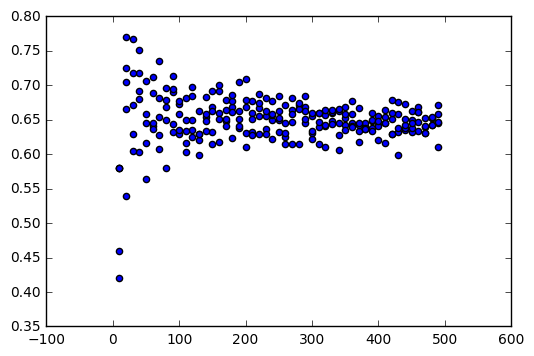

In [32]:
# Extract data as a DataFrame
run_data = batch_run.get_model_vars_dataframe()
run_data.head()
plt.scatter(run_data.N, run_data.Gini)